In this notebook well see how we can use the concept of graph cuts to find the MAP of a distribution described by a MRF. We'll see how it can be used to get the best possible segmentation given an input image.

First lets import the necessary modules and define the dataclasses we will use. We also define a function to draw graphs that we will use later.

In [24]:
from dataclasses import dataclass, field
from itertools import product

import numpy as np
from numpy.random import random, randn,randint, seed
from matplotlib import pyplot as plt

import networkx as nx
from torchvision import datasets

@dataclass(frozen=True)
class NodeWithPos:
    value: float
    _posx: int
    _posy: int
    
    def pos(self):
        return self._posx, self._posy

@dataclass(frozen=True)
class SegmentationNode(NodeWithPos):   
    pass

@dataclass(frozen=True)
class ImageNode(NodeWithPos):
    pass

def get_log_score(graph: nx.Graph):
    return sum([edge[2]['capacity'] for edge in graph.edges(data=True)])

def draw_graph(graph: nx.Graph, title='', ax=None):
    if ax is None:
        plt.figure()
        ax=plt.gca()
    if title:
        ax.set_title(title, color='w')
    nodelist = graph.nodes
    posdict = dict([(node, node.pos()) for node in nodelist])
    e_width = [6*edge[2]['capacity'] for edge in graph.edges(data=True)]
    nx.draw_networkx_nodes(graph, posdict, nodelist, ax=ax, vmin=0, vmax=1,
                           node_color=[n.value for n in nodelist],
                           margins=0.1)
    nx.draw_networkx_edges(graph, posdict, graph.edges, ax=ax, width=e_width,
                           edge_color=[e[2].get('color', 'k')
                                       for e in graph.edges(data=True)])
    
    

We will start off by showing a very simple 1d esxample as it is easier to visualize.
First we create some nodes representing an image. Here the image is simply a line of 8 pixels. 
In the chosen colormap yellow corresponds to 1 and dark purlpe is 0.

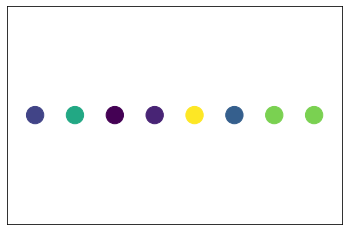

In [25]:
image_values = [0.2, 0.6, 0.0, 0.1, 1.,0.3, 0.8, 0.8]
image_nodes = [ImageNode(c, i, 0) for i, c in enumerate(image_values)]
node_pos = dict([(node, node.pos()) for node in image_nodes])


graph_0 = nx.Graph()
graph_0.add_nodes_from(image_nodes)
draw_graph(graph_0)


Then we add a second layer of nodes above the first one that represents a guess for which segment every pixel belongs to. In this example we try to segment the image into 0's and 1's. 

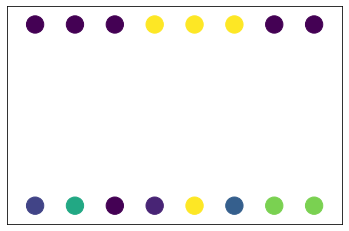

In [26]:
initial_guess = [(i//3) % 2 for i in range(len(image_values))] #000111000111...
segmentation_nodes = [SegmentationNode(guess, i, 1)
                      for i, guess in enumerate(initial_guess)]
graph_0.add_nodes_from(segmentation_nodes)

draw_graph(graph_0)


The goal of the segmentation is to end up with a segmented image that is close to the original image, but also with consisten regions. 



To achieve this we use two different log potential (lpot) functions. Both give output that are greater or equal to one, which makes visualizing them easier. Negative edges in the graph would also cause problems later.

- `similarity_lpot` gives higher log potential when the segmented image is similar to the original one. The thickness of black lines in the figure corresponds to the value of these log potentials. 

- `consistency_lpot` gives higher log potential when the segmented image is consistent, that is neighboring segmentation nodes are alike. These log potentials are marked with a red line. The 'missing' line can be seen as a line with 0 log potential.

The log score of a particular graph is then equal to the sum over the edges. 



Log score of configuration is 7.52


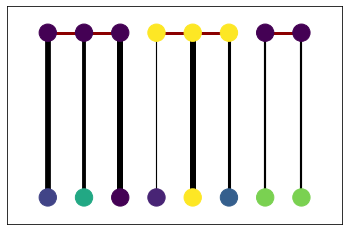

In [27]:
def similarity_lpot(seg: NodeWithPos, img: NodeWithPos):
    return (1-(seg.value - img.value)**2)
    
def concistency_lpot(node0: NodeWithPos, node1: NodeWithPos, weight: float = 1):
    return weight if node0.value == node1.value else 0

weight = 0.5

# add lpot for being close to image (vertical lines)
for img_node, seg_node in zip(image_nodes, segmentation_nodes):
    graph_0.add_edge(seg_node, img_node,
                   capacity=similarity_lpot(seg_node, img_node))

# add lpot for being close to neighbor (horizontal lines)
for seg1, seg2 in zip(segmentation_nodes[:-1], segmentation_nodes[1:]):
    graph_0.add_edge(seg1, seg2, color='darkred',
                     capacity=concistency_lpot(seg1, seg2, weight))

print(f"Log score of configuration is {get_log_score(graph_0)}")
draw_graph(graph_0)


One way to find the best configuration is to try every combination and select the best one. This is of course not feasible if we had a lot of pixels in the image.

The log score of the best graph is 10.02, its probability is 0.007423082493673226
The log score of the worst graph is 3.42, its probability is 1.0098124164474374e-05


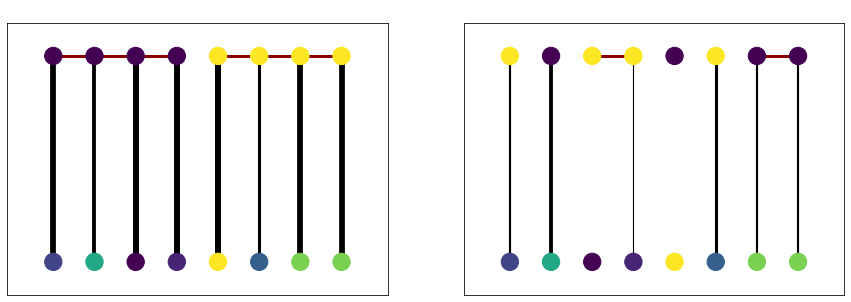

In [30]:
def get_all_combinations(image_nodes, weight):

    graphs = []
    for guess in product(*[[0,1]]*len(image_values)): #iterate over all 
        segmentation_nodes = [SegmentationNode(c, i, 1)
                            for i, c in enumerate(guess)]
        graph = nx.Graph()
        for img_node, seg_node in zip(image_nodes, segmentation_nodes):
            graph.add_edge(seg_node, img_node,
                        capacity=similarity_lpot(seg_node, img_node))
            
        for seg1, seg2 in zip(segmentation_nodes[:-1], segmentation_nodes[1:]):
            graph.add_edge(seg1, seg2, color='darkred',
                       capacity=concistency_lpot(seg1, seg2, weight))
            
            graphs.append(graph)    
    return graphs


graphs = get_all_combinations(image_nodes, weight)
scores = [np.exp(get_log_score(graph)) for graph in graphs]

best_idx = np.argmax(scores)
best_score = scores[best_idx]
best_graph = graphs[best_idx]

worst_idx = np.argmin(scores)
worst_score = scores[worst_idx]
worst_graph = graphs[worst_idx]

print(f"The log score of the best graph is {get_log_score(best_graph)}, "
      f"its probability is {best_score/sum(scores)}")
print(f"The log score of the worst graph is {get_log_score(worst_graph)}, "
      f"its probability is {worst_score/sum(scores)}")

fic, axs = plt.subplots(1, 2, figsize=(15, 5))
draw_graph(best_graph, "Best graph", axs[0])
draw_graph(worst_graph, "Worst graph", axs[1])




To be able to find the best configuration for larger graphs we need a better method than brute force. Well se how we can use minimal cuts to find it. 

To do this we first need to reformulate the graph. Instead of having many segmentation nodes, we'll only have two, one for each class. Every edge connected to a yellow node are connected to the new one and same for the purple one. Well also move the edges between the segmentation nodes so that they are between image nodes instead. 

If you look closely you should se that all the edges in the graph are preserved, they are just between differnet nodes than earlier. Thus the log potential of this new graph is equal to the original one. 

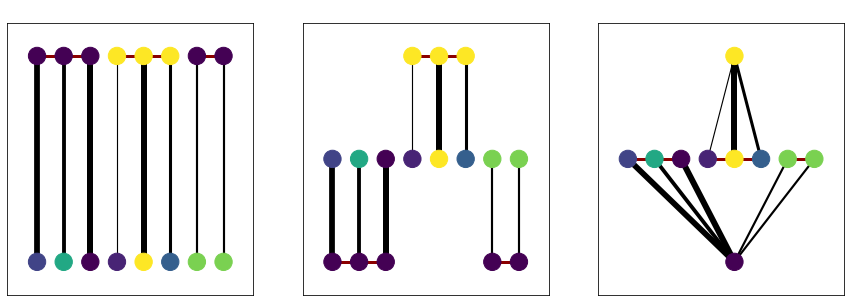

In [18]:
class_0 = SegmentationNode(0, len(image_nodes)/2, -1)
class_1 = SegmentationNode(1, len(image_nodes)/2, 1)

restructured_graph = nx.Graph()
nodes = image_nodes + [class_0, class_1]

for seg_node, img_node in zip(segmentation_nodes, image_nodes):
    class_ = class_0 if seg_node.value == 0 else class_1
    restructured_graph.add_edge(img_node, class_, 
                                capacity=similarity_lpot(img_node, class_))

for img0, img1, seg0, seg1 in zip(image_nodes[:-1], image_nodes[1:], 
                                  segmentation_nodes[:-1], segmentation_nodes[1:]):
    if seg0.value == seg1.value:
        restructured_graph.add_edge(
            img0, img1, color='darkred', capacity=weight)
        
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
repos = [SegmentationNode(guess, i, 1 if guess else -1)
                        for i, guess in enumerate(initial_guess)]
intermediate = nx.relabel_nodes(graph_0, 
                                dict(zip(segmentation_nodes, repos)))

draw_graph(graph_0, 'original graph', ax[0])
draw_graph(intermediate, 'original graph, but repositioned', ax[1])
draw_graph(restructured_graph, 'reformulated graph with same edge sum', ax[2])


What is noticeable is that this new graph is kinda divided in two. We will levrage this to find the best possible configuration. 

To segment an image you start by connecting all neighboring image nodes and connecting every image note to both the segmentation nodes. This is equivalent to saying every pixel belongs to both classes, which of course is not allowed.

Then we want to remove some edges so that the graph is separated in two. To get the best configuration we want the sum of the removed edges to be as low as possible. This problem is the same as finding the minimal cut, which is a standard problem and is therefore solved using the networkx library. 

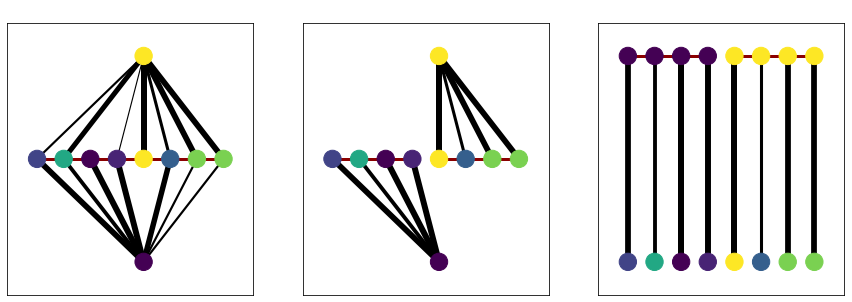

In [31]:
graph_to_cut = nx.Graph()
for seg_node, img_node in zip(segmentation_nodes, image_nodes):
    graph_to_cut.add_edge(img_node, class_0,
                                capacity=similarity_lpot(img_node, class_0))
    graph_to_cut.add_edge(img_node, class_1,
                                capacity=similarity_lpot(img_node, class_1))
    
for img0, img1 in zip(image_nodes[:-1], image_nodes[1:]):
    graph_to_cut.add_edge(img0, img1, color='darkred',capacity=weight)    

flow, (g0, g1) = nx.minimum_cut(graph_to_cut, class_0, class_1)
optimized_graph = graph_to_cut.copy()
toremove = [e for e in optimized_graph.edges 
            if not (e[0] in g0) ^ (e[1] in g1)]
optimized_graph.remove_edges_from(toremove)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
draw_graph(graph_to_cut, 'graph to cut',ax=ax[0])
draw_graph(optimized_graph, 'cut graph',ax=ax[1])
draw_graph(best_graph, 'previous representation of optimal graph',ax=ax[2])

Until now we have worked with 1d images, which is not that usefull. But fortunately it can visually be shown that we can apply this exact same method to 2d images.

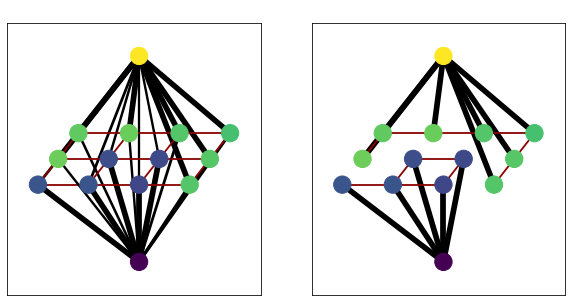

In [20]:
img = np.array([0,1,1,0,0,1,0,0,1,1,1,1]).reshape(4,3)
img = img/2 + random(img.shape)*0.1 +0.2

weight = 0.3

class_0_2d = SegmentationNode(0, (img.shape[0])/2, -3)
class_1_2d = SegmentationNode(1, img.shape[0]/2, img.shape[1]+2)

nodes_2d = np.array([ImageNode(value, *np.array([[1., 0.4], [0, 1]])@idx)
                      for idx, value in zip(np.ndindex(img.shape), img.ravel())
                      ]).reshape(img.shape)
graph_2d = nx.Graph()
for node in nodes_2d.ravel():
    graph_2d.add_edge(node, class_0_2d,
                      capacity=similarity_lpot(node, class_0_2d))
    graph_2d.add_edge(node, class_1_2d,
                      capacity=similarity_lpot(node, class_1_2d))

for i, j in np.ndindex(img[:-1, :].shape):
    graph_2d.add_edge(nodes_2d[i, j], nodes_2d[i+1, j], color='darkred',
                      capacity=weight)

for i, j in np.ndindex(img[:, :-1].shape):
    graph_2d.add_edge(nodes_2d[i, j], nodes_2d[i, j+1], color = 'darkred',
                      capacity=weight)
    
flow, (g0, g1) = nx.minimum_cut(graph_2d, class_0_2d, class_1_2d)

optimized_graph_2d = graph_2d.copy()
toremove = [e for e in optimized_graph_2d.edges
            if not (e[0] in g0) ^ (e[1] in g1)]
optimized_graph_2d.remove_edges_from(toremove)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_graph(graph_2d, 'graph to cut',ax=ax[0])
draw_graph(optimized_graph_2d, 'segmented graph', ax=ax[1])


To use this on images we define a function that takes an image (with values between 0 and 1), as input and returns the segmented output image.  

In [21]:
def segment_image(img, weight):
    class_0 = SegmentationNode(0, None, None)
    class_1 = SegmentationNode(1, None, None)
    nodes = np.array([ImageNode(v, i, j)
                      for v, (i, j) in zip(img.ravel(), np.ndindex(img.shape))
                     ]).reshape(img.shape)
    graph = nx.Graph()
    for node in nodes.ravel():
        graph.add_edge(node, class_0,
                       capacity=similarity_lpot(node, class_0))
        graph.add_edge(node, class_1,
                       capacity=similarity_lpot(node, class_1))

    for i, j in np.ndindex(img[:-1, :].shape):
        graph.add_edge(nodes[i, j], nodes[i+1, j], capacity=weight)

    for i, j in np.ndindex(img[:, :-1].shape):
        graph.add_edge(nodes[i, j], nodes[i, j+1], capacity=weight)

    flow, (g0, g1) = nx.minimum_cut(graph, class_0, class_1)

    output = np.zeros_like(img)
    for node in g1:
        if isinstance(node, ImageNode):
            output[node.pos()]=1
        
    return output

We try this out on the mnist dataset and we can see that it manages to segment the image quite well.

It is worth noting that this segmentation technique struggle with thin lines and is not capable of working on large images due to the complexity of the minimal cut algorithm.

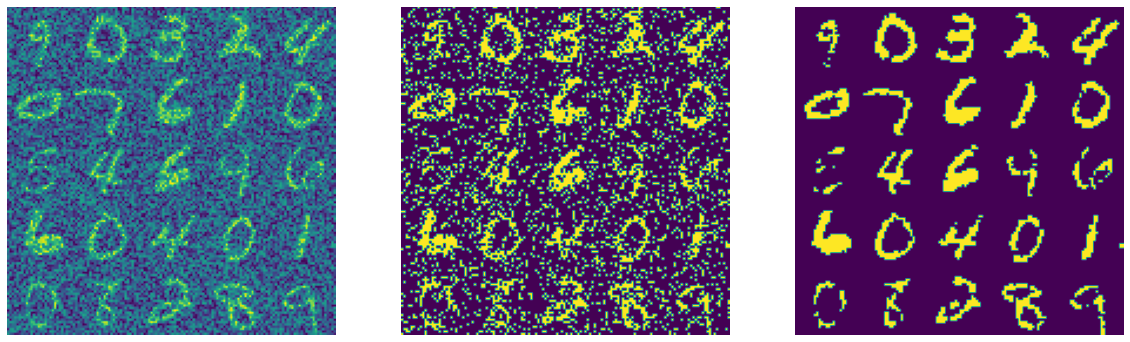

In [35]:
dataset = datasets.MNIST('data', train=False, download=True)
noise = 0.6
np.random.seed(hash('mrf')%2**32)

def get_img(idx):
    img = np.array(dataset[idx][0])
    return (1-noise)*img/255 + noise*random(img.shape)


img_large = np.block([[get_img(randint(0, len(dataset)))
                       for j in range(5)]
                       for i in range(5)])

segmented = segment_image(img_large, 0.1)

fig, axs = plt.subplots(1,3,figsize = (20, 8))
for ax in axs:
    ax.axis('off')
axs[0].imshow(img_large)
axs[1].imshow(np.round(img_large))
axs[2].imshow(segmented)
